In [1]:
import matplotlib.pyplot as plt
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.samples.simple import AsphericSinglet
from optiland.physical_apertures.rectangular import RectangularAperture

In [2]:
lens = AsphericSinglet()
# we have a bug here - after we define the physical aperture, the system until the image plane is no longer
# shown
im_surf = lens.surface_group.surfaces[-1]
im_surf.aperture = RectangularAperture(x_min=-1, x_max=1, y_min=-1, y_max=1)

# move image surface out of focus
lens.set_thickness(20, surface_number=2)

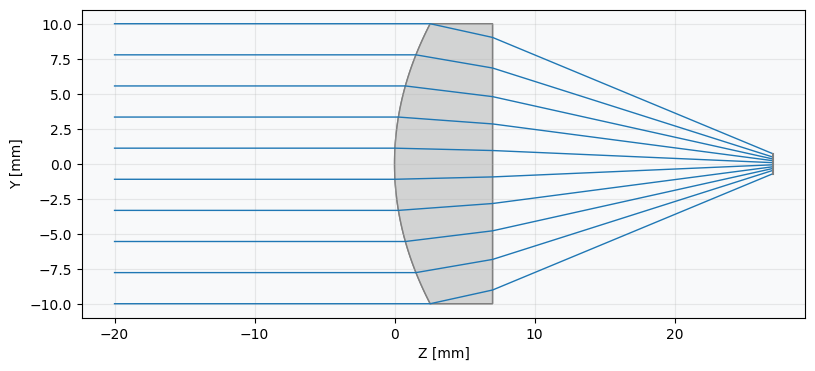

In [3]:
lens.draw(num_rays=10)

In [4]:
lens.info()

╒════╤═════════════════════╤═══════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type                │ Comment   │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═════════════════════╪═══════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar              │           │      inf │         inf │ Air        │       0 │       10        │
│  1 │ Stop - Even Asphere │           │       20 │           7 │ N-SF11     │       0 │       10        │
│  2 │ Planar              │           │      inf │          20 │ Air        │       0 │        8.461    │
│  3 │ Planar              │           │      inf │         nan │ Air        │       0 │        0.612938 │
╘════╧═════════════════════╧═══════════╧══════════╧═════════════╧════════════╧═════════╧═════════════════╛


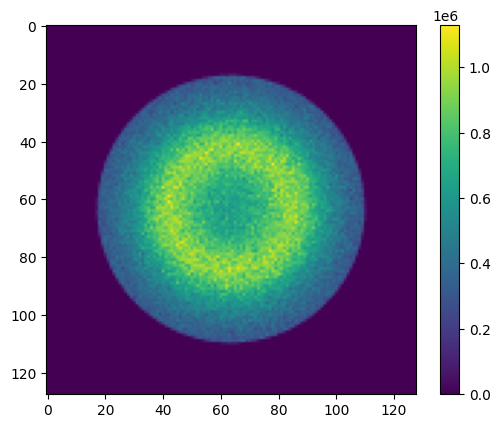

In [5]:
irradiance = IncoherentIrradiance(lens, n_rays=1_000_000, detector_surface=-1)

plt.imshow(irradiance.irr_data[0][0][0])
plt.colorbar()
plt.show()